# Example 03: Cleaning a Larger Dataset with ICA

Here we use ICA to clean a larger data and find some interesting patterns!

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import numpy as np

from notebooks.feature_extraction import get_autoregression_features

plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

np.random.seed(42)

def read_kaggle_json(filepath):
    filepath = os.path.expanduser(filepath)
    username = None
    token = None
    with open(filepath, "r") as file:
        config = json.load(file)
        username = config.get("username")
        token = config.get("key")
    return username, token


kaggle_json_filepath = "/workspaces/fall-2024-class-08/kaggle/kaggle.json"
kaggle_username, kaggle_api_token = read_kaggle_json(kaggle_json_filepath)

if kaggle_username and kaggle_api_token:
    os.environ["KAGGLE_USERNAME"] = kaggle_username
    os.environ["KAGGLE_KEY"] = kaggle_api_token

import kaggle

dataset_name = "andrewmvd/sp-500-stocks"
download_location = "/workspaces/fall-2024-class-08/downloads"

kaggle.api.authenticate()
kaggle.api.dataset_download_files(
    dataset_name, path=download_location, unzip=True
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks


In [11]:
stocks_file_path = "/workspaces/fall-2024-class-08/downloads/sp500_stocks.csv"
index_file_path = "/workspaces/fall-2024-class-08/downloads/sp500_index.csv"
companies_file_path = (
    "/workspaces/fall-2024-class-08/downloads/sp500_companies.csv"
)

stocks_df = pd.read_csv(stocks_file_path)
index_df = pd.read_csv(index_file_path)
companies_df = pd.read_csv(companies_file_path)
dates = stocks_df["Date"].unique()
symbols = companies_df["Symbol"].unique()
print(symbols)

['AAPL' 'NVDA' 'MSFT' 'GOOG' 'GOOGL' 'AMZN' 'META' 'BRK-B' 'TSLA' 'AVGO'
 'LLY' 'WMT' 'JPM' 'V' 'UNH' 'XOM' 'ORCL' 'MA' 'PG' 'HD' 'COST' 'JNJ'
 'ABBV' 'BAC' 'NFLX' 'KO' 'CRM' 'CVX' 'MRK' 'TMUS' 'AMD' 'PEP' 'LIN' 'WFC'
 'CSCO' 'ACN' 'ADBE' 'TMO' 'MCD' 'BX' 'PM' 'ABT' 'NOW' 'AXP' 'TXN' 'MS'
 'GE' 'IBM' 'QCOM' 'CAT' 'ISRG' 'DHR' 'INTU' 'VZ' 'DIS' 'AMGN' 'UBER' 'GS'
 'CMCSA' 'NEE' 'RTX' 'PFE' 'T' 'AMAT' 'SPGI' 'BKNG' 'LOW' 'BLK' 'PGR'
 'UNP' 'SYK' 'ETN' 'HON' 'SCHW' 'KKR' 'TJX' 'LMT' 'ANET' 'BSX' 'VRTX' 'C'
 'COP' 'ADP' 'PANW' 'ADI' 'MDT' 'MU' 'UPS' 'CB' 'NKE' 'FI' 'DE' 'SBUX'
 'GILD' 'MMC' 'PLD' 'BMY' 'REGN' 'PLTR' 'AMT' 'LRCX' 'SO' 'ICE' 'BA'
 'INTC' 'ELV' 'MDLZ' 'HCA' 'KLAC' 'SHW' 'DUK' 'WM' 'CI' 'ABNB' 'EQIX' 'MO'
 'WELL' 'DELL' 'TT' 'CTAS' 'MCO' 'APH' 'GD' 'ZTS' 'SNPS' 'GEV' 'CEG' 'CME'
 'PH' 'AON' 'CDNS' 'PYPL' 'ITW' 'CL' 'CMG' 'CRWD' 'USB' 'MSI' 'PNC' 'TDG'
 'MAR' 'NOC' 'ECL' 'CVS' 'APD' 'MMM' 'EOG' 'TGT' 'BDX' 'ORLY' 'FDX' 'FCX'
 'CARR' 'NXPI' 'CSX' 'MCK' 'SPG' 'RSG' 'WMB' 'COF' 'A

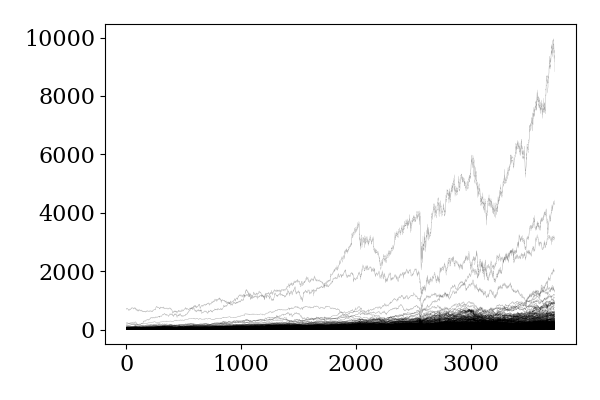

In [12]:
# Specify the target symbol to predict, number of days of history to use in the
# autoregressive model, and number of days forward to predict.
# Increasing the history (to 20, 50, etc.) will increase the smoothness.
n_days_history = 1
n_days_forward = 1

# Get the dataset
x_features = get_autoregression_features(
    dates, stocks_df, n_days_history, n_days_forward, predictor_symbols=symbols
)

plt.figure(figsize=(6, 4))
plt.plot(x_features, color="k", linewidth=0.1, alpha=0.5)
plt.tight_layout()

In [13]:
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler

from notebooks.ica_tools import (
    perform_n_components_search,
    compute_gaussianity_measure,
    rebuild_features_without_noise,
)

In [14]:
# Remove NaNs
x_features[np.isnan(x_features)] = 0

# Standardize
scaler = StandardScaler()
x_features_scaled = scaler.fit_transform(x_features)

best_n_components = perform_n_components_search(x_features_scaled)

Checked n = 2, peak to avg. Gaussianity ratio = 1.1357160622082068
Checked n = 3, peak to avg. Gaussianity ratio = 1.38436567022882
Checked n = 4, peak to avg. Gaussianity ratio = 1.7405411557835098
Checked n = 5, peak to avg. Gaussianity ratio = 2.3806363265641917
Checked n = 6, peak to avg. Gaussianity ratio = 2.0543853525626266
Checked n = 7, peak to avg. Gaussianity ratio = 2.5049707966709436


/workspaces/fall-2024-class-08/.venv/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Checked n = 8, peak to avg. Gaussianity ratio = 7.522654220747216


/workspaces/fall-2024-class-08/.venv/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Checked n = 9, peak to avg. Gaussianity ratio = 2.3940032497809725
Checked n = 10, peak to avg. Gaussianity ratio = 2.886188403093043
Checked n = 11, peak to avg. Gaussianity ratio = 2.838743851236346
Checked n = 12, peak to avg. Gaussianity ratio = 3.2888226389125985
Checked n = 13, peak to avg. Gaussianity ratio = 3.842732847803338
Checked n = 14, peak to avg. Gaussianity ratio = 4.294482541694291
Checked n = 15, peak to avg. Gaussianity ratio = 3.095310443688224
Checked n = 16, peak to avg. Gaussianity ratio = 2.640088612500718
Checked n = 17, peak to avg. Gaussianity ratio = 2.756564750558673
Checked n = 18, peak to avg. Gaussianity ratio = 2.7713490934575655
Checked n = 19, peak to avg. Gaussianity ratio = 2.858331998947082
Checked n = 20, peak to avg. Gaussianity ratio = 2.036674752088923
Checked n = 21, peak to avg. Gaussianity ratio = 6.907883936079393
Checked n = 22, peak to avg. Gaussianity ratio = 3.4697425822756998
Checked n = 23, peak to avg. Gaussianity ratio = 2.58459822

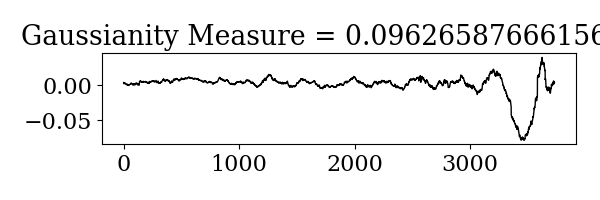

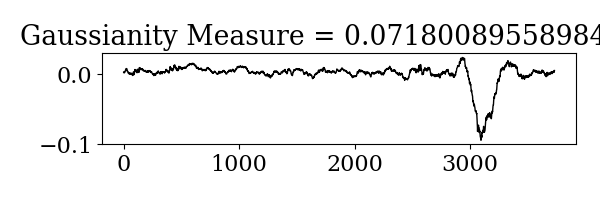

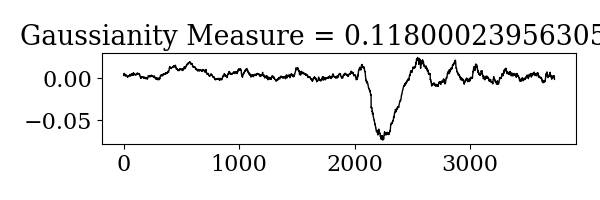

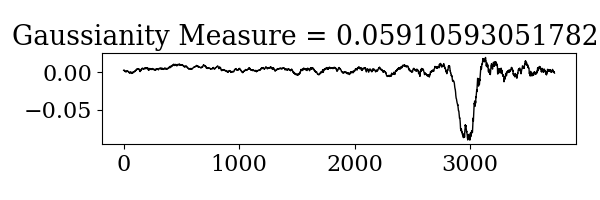

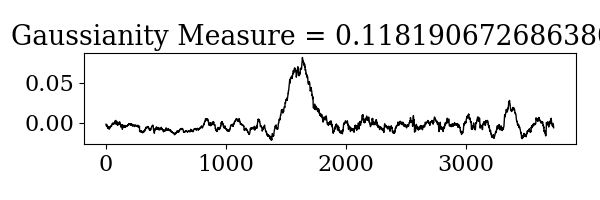

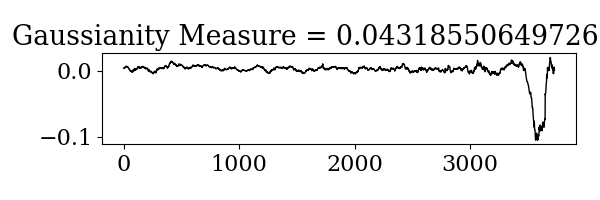

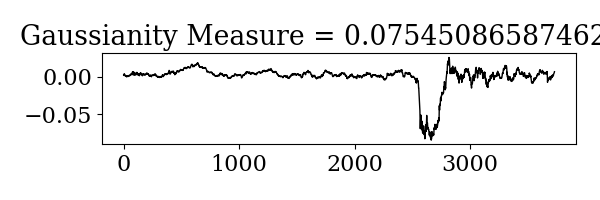

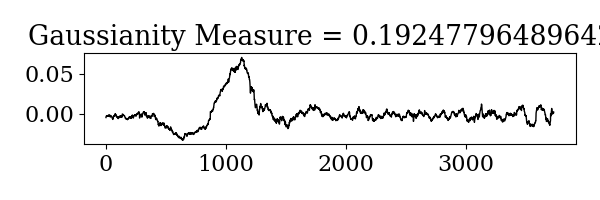

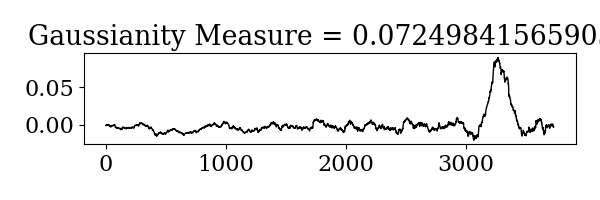

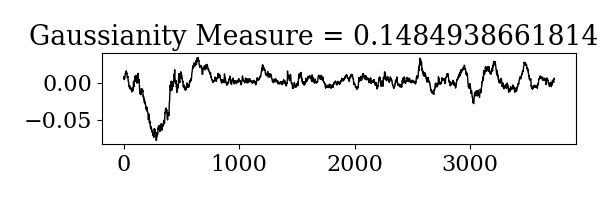

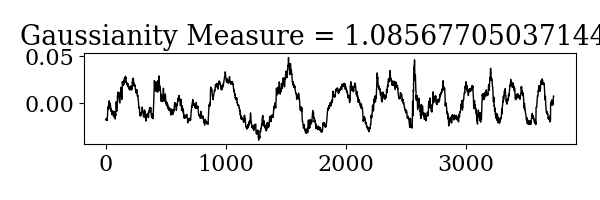

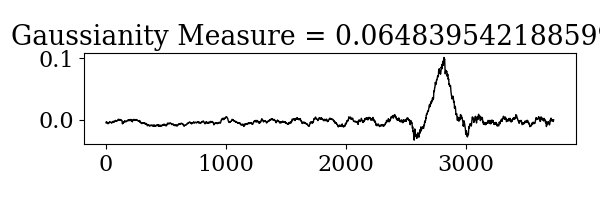

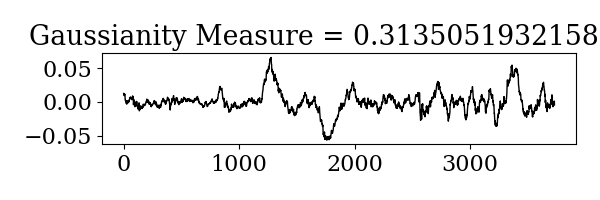

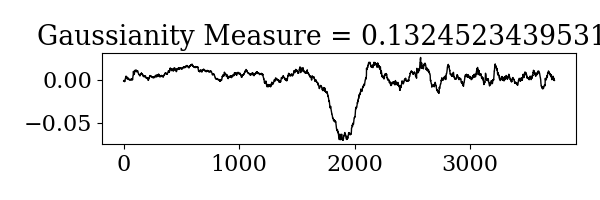

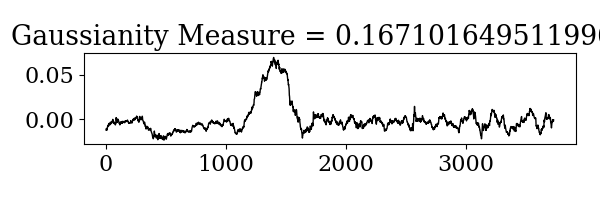

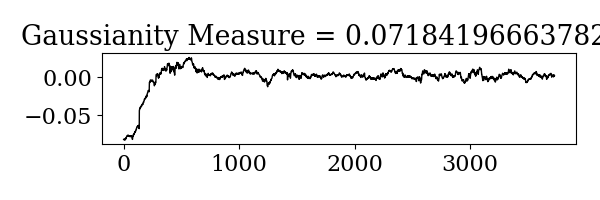

In [15]:
ica = FastICA(
    n_components=21,
    whiten="arbitrary-variance",
    tol=1e-7,
    max_iter=500,
    random_state=42,
)

x_features_transformed = ica.fit_transform(x_features_scaled)

for idx in range(x_features_transformed.shape[1]):
    signal_component = x_features_transformed[:, idx]
    gaussianity_measure = compute_gaussianity_measure(signal_component)
    plt.figure(figsize=(6, 2))
    plt.plot(signal_component, color="k", linewidth=1)
    plt.title("Gaussianity Measure = {}".format(gaussianity_measure))
    plt.tight_layout()

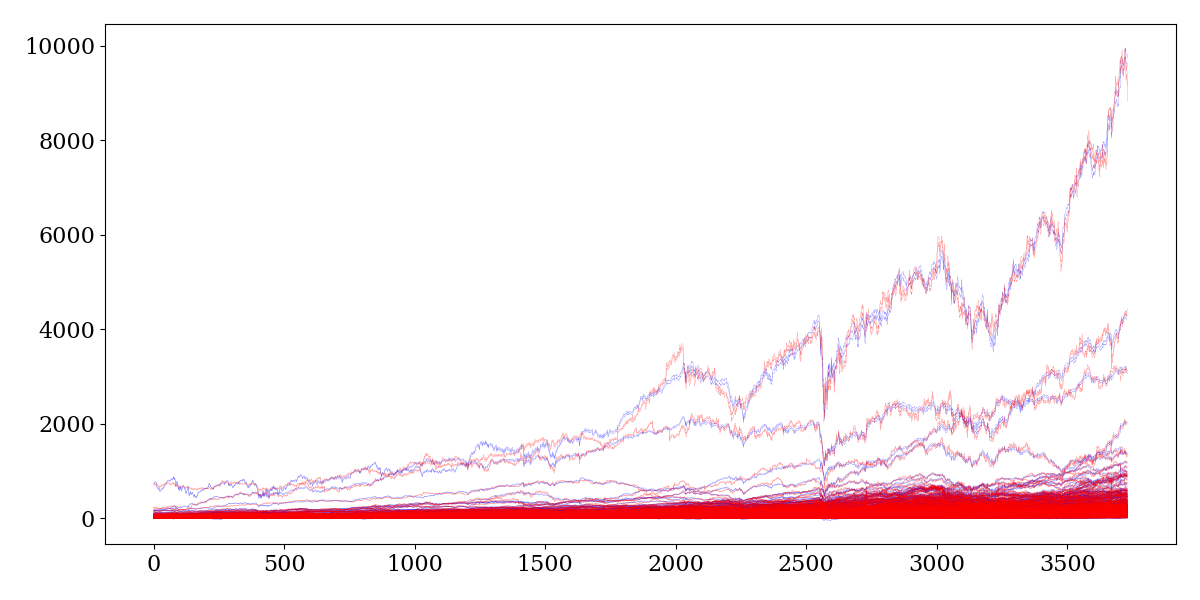

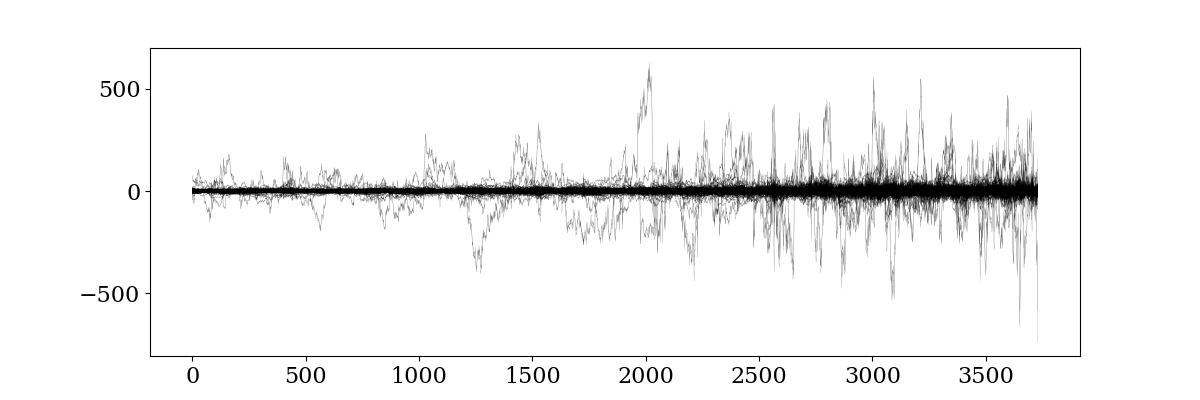

In [16]:
x_smooth_original_scale, delta = rebuild_features_without_noise(
    ica, scaler, x_features, x_features_transformed
)

plt.figure(figsize=(12, 6))
plt.plot(x_smooth_original_scale, color="b", linewidth=0.15, alpha=0.75)
plt.plot(x_features, color="r", linewidth=0.15, alpha=0.75)
plt.tight_layout()

plt.figure(figsize=(12, 4))
_ = plt.plot(delta, color="k", linewidth=0.1, alpha=0.75)